In [1]:
using Pkg
# Pkg.add("Plots")
# Pkg.add("DifferentialEquations")
# Pkg.add("LinearAlgebra")
# Pkg.add("SparseArrays")
# Pkg.add("PolygonOps")
# Pkg.add("DataFrames")
# Pkg.add("Makie")
# Pkg.add("ColorSchemes")
# Pkg.add("LibGEOS")
# Pkg.add("GeoInterface")
# Pkg.add("PlotlyJS")
# Pkg.add("GLMakie")
# Pkg.add("GeometryBasics")
# Pkg.add("GLM")
# Pkg.add("ProgressMeter")

In [1]:
using Plots
using DifferentialEquations
using LinearAlgebra
using SparseArrays
using PolygonOps
using DataFrames
using ColorSchemes
using LibGEOS
using GeoInterface
using Arpack
using GLMakie
using GeometryBasics
using GLM
using Statistics
using ProgressMeter
using Base.Threads

In [2]:
l = 4
L = 1
# D = 1.5 # Fractal dimension

1

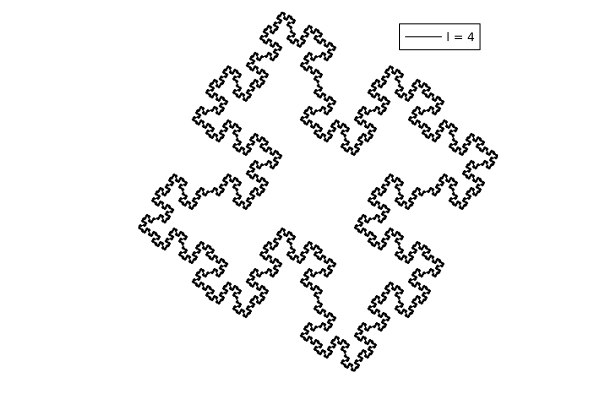

In [ ]:
function koch_curve_iterative(l, L)
    """Generates the points of a Koch curve fractal iteratively.

    # Arguments
    - `l`: The recursion level of the Koch curve. Higher values result in more detailed fractals.
    - `L`: The length of the initial line segment.

    # Returns
    - A vector of 2D points representing the vertices of the generated Koch curve.
    """
    # Initial line segment from (0, 0) to (L, 0)
    points = [[0.0, 0.0], [L, 0.0]]

    # Base case: if recursion level is zero, return initial line
    if l == 0
        return points
    end

    # Transformation steps represent subdivision and shaping of each segment
    transform = [0.0 + 0.0im, 
                 0.25 + 0im,
                 0.25 + 0.25im, 
                 0.5 + 0.25im, 
                 0.5 + 0.0im,
                 0.5 - 0.25im, 
                 0.75 - 0.25im, 
                 0.75 + 0im, 
                 1 + 0im]

    # Perform l iterations to construct the fractal
    for _ in 1:l
        new_points = ComplexF64[]

        # Replace each segment with the transformed shape
        for i in 1:length(points)-1
            p_i = points[i][1] + im*points[i][2]
            p_f = points[i+1][1] + im*points[i+1][2]
            segment = p_f - p_i

            # Append transformed points along the segment
            append!(new_points, [(p_i + segment*p) for p in transform])
        end

        # Convert complex numbers back to 2D points
        points = [[real(q), imag(q)] for q in new_points]
    end

    return points
end


function rotate_90deg(points)
    """Rotates a list of 2D points 90 degrees counterclockwise.

    # Arguments
    - `points`: A vector of 2D points.

    # Returns
    - A new vector of points rotated by 90 degrees CCW.
    """
    return [[-p[2], p[1]] for p in points]
end


function find_borders(vertices)
    """
    Finds the bounding box (min and max x and y values) for a set of 2D points.

    # Arguments
    - `vertices`: A vector of 2D points.

    # Returns
    - A tuple containing (x_min, x_max, y_min, y_max).
    """
    x_min = minimum([p[1] for p in vertices])
    x_max = maximum([p[1] for p in vertices])
    y_min = minimum([p[2] for p in vertices])
    y_max = maximum([p[2] for p in vertices])

    return x_min, x_max, y_min, y_max
end

# Generate four Koch curves for the fractal drum
x_points1 = koch_curve_iterative(l, L)                      # Bottom side
y_points1 = rotate_90deg(koch_curve_iterative(l, L))        # Left side (rotated)
x_points2 = [[p[1], p[2] + L] for p in x_points1]           # Top side (translated)
y_points2 = [[p[1] + L, p[2]] for p in y_points1]           # Right side (translated)

# Combine all sides to form a closed loop
vertices = vcat(x_points1, y_points2, reverse(x_points2), reverse(y_points1))

# Get bounding box for plot limits
x_min, x_max, y_min, y_max = find_borders(vertices)

# Plot the complete fractal drum
fractal_plot = Plots.plot([p[1] for p in vertices], 
                          [p[2] for p in vertices], 
                          label="l = $l", linewidth=1, legend=true, 
                          xlim=(x_min, x_max), ylim=(y_min, y_max), 
                          aspect_ratio=:equal, color=:black, grid=false, axis=false)

# Optional: save the plot
# Plots.savefig(fractal_plot, "fractal_drum_plot.png")


In [ ]:
function square_lattice(lmax, L)
    """
    Creates a square grid (lattice) based on the resolution of the Koch curve's maximum iteration level.

    # Arguments
    - `lmax`: The maximum recursion level of the Koch curve, used to determine grid resolution.
    - `L`: The length of the base side of the fractal shape.

    # Returns
    - `square_grid`: A 2D square matrix initialized with zeros, representing the lattice.
    - `d`: The grid spacing based on the smallest segment at iteration `lmax`.
    - `L_l`: The total adjusted length of the square, including all margin offsets.
    """
    # Grid spacing based on the smallest segment of the Koch curve at level lmax
    d = L / (4^lmax)

    # Array of spacings from each level of the Koch curve
    d_arr = [L / 4^l for l in 1:lmax]

    # Total effective length of the square including extra space from fractal extensions
    L_l = L + 2 * sum(d_arr)

    # Number of grid points along each axis, rounded to the nearest integer
    N = round(Int, L_l / d)

    # Compute all four sides of the Koch square for possible grid alignment (unused here but precomputed)
    x_points1 = koch_curve_iterative(l, L)                      # Bottom
    y_points1 = rotate_90deg(koch_curve_iterative(l, L))        # Left
    x_points2 = [[p[1], p[2] + L] for p in x_points1]           # Top (translated)
    y_points2 = [[p[1] + L, p[2]] for p in y_points1]           # Right (translated)

    # Create an (N+1) x (N+1) zero matrix to represent the square lattice grid
    square_grid = zeros(N + 1, N + 1)

    return square_grid, d, L_l
end


square_lattice (generic function with 1 method)

In [5]:
# l_test, L_test = 4, 1
# square_grid_test, d_test, L_l_test = square_lattice(l_test, L_test)
# x_points1_test = koch_curve_iterative(l_test, L_test)
# y_points1_test = rotate_90deg(koch_curve_iterative(l_test, L_test))
# x_points2_test = [[p[1], p[2] + L_test] for p in x_points1_test]
# y_points2_test = [[p[1] + L_test, p[2]] for p in y_points1_test]
# vertices_test = vcat(x_points1_test, y_points2_test, reverse(x_points2_test), reverse(y_points1_test))
# println("For l = $l_test and L = $L_test:")
# println("The size of the lattice constant is: d = $d_test")
# println("The size of the lattice is: $L_l_test")
# println("The number of points needed to make up the fractal is: $(length(vertices_test) - 4)")
# println("The approximate number of points in the lattices is: (L_l/d + 1)^2 = $(round(Int, (L_l_test/d_test + 1)^2))")
# println("The approximate number of points inside of the fractal is: (L_l/d + 1)^2*L/L_l = $(round(Int, (L_l_test/d_test + 1)^2*(L_test/L_l_test)^2))")
# println("The number of points in the square grid is: $(size(square_grid_test, 1)^2)")

In [ ]:
### NB! The ray-casting methods in this cell do not work

function ray_intersects_segment(origin, direction, p1, p2)
    """
    Checks whether a ray starting at `origin` and moving in `direction` intersects the line segment from `p1` to `p2`.

    # Returns
    - `true` if the ray intersects the segment.
    - `false` otherwise.
    """
    # Vector from segment start to ray origin
    v1 = origin .- p1
    # Segment vector
    v2 = p2 .- p1
    # Perpendicular to direction (for 2D cross product)
    v3 = [-direction[2], direction[1]]

    dotproduct = dot(v2, v3)

    # If dot product is nearly zero, vectors are parallel — no intersection
    if abs(dotproduct) < 1e-6
        return false
    end

    # Compute intersection parameters
    w1 = dot(v1, v3) / dotproduct
    w2 = dot(v1, v2) / dotproduct

    # Check that intersection lies on the ray and within the segment
    if w1 >= 0 && w2 >= 0 && w2 <= 1
        return true
    end

    return false
end

function ray_cast(origin, direction, vertices)
    """
    Counts how many times a ray from `origin` in `direction` intersects the polygon defined by `vertices`.
    
    # Returns
    - The number of intersections found.
    """
    intersections = 0

    # Check all edges of the polygon
    for i in 1:length(vertices)-1
        if ray_intersects_segment(origin, direction, vertices[i], vertices[i+1])
            intersections += 1
        end
    end

    return intersections
end

function ray_casting(square_grid, d, vertices, x_min, y_min)
    """
    Performs ray casting on a grid to determine whether each point is inside, outside, or on the edge of a polygon.
    
    # Arguments
    - `square_grid`: The grid to label with inside (1), outside (-1), or edge (0) values.
    - `d`: Grid spacing.
    - `vertices`: Vertices of the polygon (should be closed).
    - `x_min`, `y_min`: Minimum coordinates used for translating grid points.
    
    # Returns
    - The modified `square_grid` with points labeled by location relative to the polygon.
    """
    N = size(square_grid)[1]

    # Area-based orientation check (currently disabled)
    A = 1
    if A == 0
        # Shoelace formula for area — determines winding direction
        for i in 1:length(vertices)-1
            x_i, y_i = vertices[i]
            x_next, y_next = vertices[i+1]
            A += 0.5 * (x_i * y_next - x_next * y_i)
        end

        # Warn if shape is invalid or improperly oriented
        if A == 0
            println("$A = 0 ==> vertices is not a valid closed shape.")
        elseif A < 0
            println("$A < 0 ==> vertices are clockwise, flip them.")
        elseif A > 0
            println("$A > 0 ==> vertices are counterclockwise, all good.")
        end
    end

    # Small offset to avoid hitting vertices exactly (which causes numerical instability)
    epsilon = 1e-6

    # Loop through each grid point
    for i in 1:N
        for j in 1:N
            # Compute the real-world coordinate of the grid point
            origin = [x_min + (i-1) * d, y_min + (j-1) * d]
            # Shoot ray vertically (up) with small perturbation to y to avoid ambiguous hits
            direction = [0, 1 + epsilon]

            intersections = ray_cast(origin, direction, vertices)

            if intersections % 2 == 1
                square_grid[i, j] = 1  # Point is inside polygon
            elseif any(isapprox(origin, v, atol=1e-6) for v in vertices)
                square_grid[i, j] = 0  # Point is on a vertex
            else
                square_grid[i, j] = -1  # Point is outside polygon
            end
        end
    end

    return square_grid
end

ray_casting (generic function with 1 method)

In [ ]:
function classify_points_on_grid(square_grid, vertices, x_min, y_min, d)
    """
    Classifies each point in a 2D grid as inside, on the edge, or outside a polygon defined by `vertices`.

    # Arguments
    - `square_grid`: A matrix representing the grid to be filled with classification labels.
    - `vertices`: A list of 2D points defining the polygon.
    - `x_min`, `y_min`: The minimum x and y values of the grid (origin offset).
    - `d`: Grid spacing between each point.

    # Returns
    - The updated `square_grid` with:
        - `1` for points inside the polygon,
        - `0` for points on the boundary,
        - `-1` for points outside the polygon.
    """
    N = size(square_grid)[1]  # Grid size (assumes square grid)

    # Area-based orientation check (disabled by A == 1)
    A = 1
    if A == 0
        # Shoelace formula to determine polygon orientation
        for i in 1:length(vertices)-1
            x_i, y_i = vertices[i]
            x_next, y_next = vertices[i+1]
            A += 0.5 * (x_i * y_next - x_next * y_i)
        end

        # Inform user of orientation or invalid shape
        if A == 0
            println("$A = 0 ==> vertices is not a valid closed shape.")
        elseif A < 0
            println("$A < 0 ==> vertices are clockwise, flip them.")
        elseif A > 0
            println("$A > 0 ==> vertices are counterclockwise, all good.")
        end
    end

    # Set up coordinate vectors based on grid spacing
    x_points = x_min .+ (0:N-1) .* d
    y_points = y_min .+ (0:N-1) .* d

    # Initialize progress bar for tracking classification progress
    total_iterations = N * N
    progress = Progress(total_iterations, 1)

    # Parallel loop to classify each point in the grid
    @threads for i in 1:N
        if i <= 2
            println("jess", i)  # Debug print for early iterations
        end

        for j in 1:N
            point = [x_points[i], y_points[j]]

            # Use inpolygon function to determine point location
            result = inpolygon(point, vertices)

            if result == 1
                square_grid[i, j] = 1  # Inside
            elseif result == -1
                square_grid[i, j] = 0  # On the edge
            elseif result == 0
                square_grid[i, j] = -1  # Outside
            end

            next!(progress)  # Update progress bar
        end
    end

    return square_grid
end

classify_points_on_grid (generic function with 1 method)

In [ ]:
function check_if_point_within_polygon(vertices_geom, point_geom)
    """
    Uses LibGEOS to determine if a given point geometry lies strictly within a polygon geometry.

    # Returns
    - `true` if the point is inside the polygon (not on the edge),
    - `false` otherwise.
    """
    if LibGEOS.within(point_geom, vertices_geom)
        return true
    end
    return false
end

function update_square_grid_using_within(square_grid, x_points1, y_points1, x_points2, y_points2, x_min, y_min, d)
    """
    Fills the grid using LibGEOS geometry methods by checking whether each point lies inside, on, or outside the fractal polygon.
    
    # Arguments
    - `square_grid`: Grid to populate with values based on point position.
    - `x_points1`, `y_points1`, `x_points2`, `y_points2`: Segments forming the boundary of the shape.
    - `x_min`, `y_min`: Grid offset coordinates.
    - `d`: Spacing between grid points.
    
    # Returns
    - The updated `square_grid` with:
        - `1` for inside,
        - `0` for boundary points,
        - `-1` for outside.
    """
    N = size(square_grid)[1]  # Grid size

    # Construct the full polygon as a closed loop using boundary segments
    vertices = vcat(
        [(p[1], p[2]) for p in x_points1],
        [(p[1], p[2]) for p in y_points2],
        [(p[1], p[2]) for p in reverse(x_points2)],
        [(p[1], p[2]) for p in reverse(y_points1)]
    )

    # Optional check for polygon validity/orientation (currently disabled)
    A = 1
    if A == 0
        for i in 1:length(vertices)-1
            x_i, y_i = vertices[i]
            x_next, y_next = vertices[i+1]
            A += 0.5*(x_i*y_next - x_next*y_i)
        end

        if A == 0
            println("$A = 0 ==> vertices is not a valid closed shape.")
        elseif A < 0
            println("$A < 0 ==> vertices are clockwise, flip them.")
        elseif A > 0
            println("$A > 0 ==> vertices are counterclockwise, all good.")
        end
    end

    # Construct LibGEOS polygon geometry from vertices
    polygon_str = "POLYGON((" * join([string(p[1]) * " " * string(p[2]) for p in vcat(vertices, [vertices[1]])], ", ") * "))"
    vertices_geom = LibGEOS.readgeom(polygon_str)

    # Initialize progress bar
    total_iterations = N*N
    progress = Progress(total_iterations, 1)

    # Loop through all grid points in parallel
    @threads for i in 1:N
        for j in 1:N
            # Compute grid point coordinates
            point = [x_min + (i-1)*d, y_min + (j-1)*d]

            # Convert point to GEOS geometry
            point_geom = LibGEOS.readgeom("POINT($(point[1]) $(point[2]))")

            # Use GEOS to test spatial relationship
            if check_if_point_within_polygon(vertices_geom, point_geom)
                square_grid[i, j] = 1  # Inside
            elseif point in x_points1 || point in y_points1 || point in x_points2 || point in y_points2
                square_grid[i, j] = 0  # On boundary (heuristic via point list membership)
            else
                square_grid[i, j] = -1  # Outside
            end

            next!(progress)
        end
    end

    return square_grid
end

update_square_grid_using_within (generic function with 1 method)

In [ ]:
function sum_angles(point, vertices)
    """
    Computes the total angle swept around `point` by the edges of the polygon defined by `vertices`.
    Used to approximate the winding number of the point relative to the polygon.

    # Arguments
    - `point`: A 2D point to check (e.g. `[x, y]`).
    - `vertices`: A list of 2D points defining the polygon in order.

    # Returns
    - The total angle sum around the point. If approximately `2π`, the point is inside.
    """
    anglesum = 0

    # Loop over each edge of the polygon
    for i in 1:length(vertices)-1
        v1 = vertices[i] .- point
        v2 = vertices[i+1] .- point
        if norm(v1) == 0 || norm(v2) == 0
            continue  # Skip if point coincides with a vertex
        else
            dot_product = dot(v1, v2)
            costheta = clamp(dot_product / (norm(v1) * norm(v2)), -1, 1)
            anglesum += acos(costheta)  # Use acos to get angle between vectors
        end
    end

    return anglesum
end

function update_square_grid(square_grid, vertices, x_min, y_min)
    """
    Uses the angle summation method (winding number) to classify each point in a grid
    as inside (`1`), on the boundary (`0`), or outside (`-1`) relative to a polygon.
    
    # Arguments
    - `square_grid`: A 2D matrix representing the domain to classify.
    - `vertices`: Polygon boundary points.
    - `x_min`, `y_min`: The bottom-left corner of the grid.
    
    # Returns
    - The updated grid with classification values.
    """
    N = size(square_grid)[1]

    # Optional orientation check 
    A = 1
    if A == 0
        for i in 1:length(vertices)-1
            x_i, y_i = vertices[i]
            x_next, y_next = vertices[i+1]
            A += 0.5 * (x_i * y_next - x_next * y_i)
        end

        if A == 0
            println("$A = 0 ==> vertices is not a valid closed shape.")
        elseif A < 0
            println("$A < 0 ==> vertices are clockwise, flip them.")
        elseif A > 0
            println("$A > 0 ==> vertices are counterclockwise, all good.")
        end
    end

    tol = 1e-6  # Tolerance for floating point comparison

    for i in 1:N
        for j in 1:N
            point = [x_min + (i-1)*d, y_min + (j-1)*d]
            anglesum = sum_angles(point, vertices)
            winding_number = anglesum / (2 * π)

            # NOTE: x_points1, x_points2, etc. must be defined globally for this check to work
            if point in x_points1 || point in y_points1 || point in x_points2 || point in y_points2
                square_grid[i, j] = 0  # On the boundary (crude check)
            elseif abs(winding_number - round(winding_number)) < tol && round(winding_number) % 2 == 1
                square_grid[i, j] = 1  # Inside if winding number is odd
            else
                square_grid[i, j] = -1  # Outside
            end
        end
    end

    return square_grid
end

update_square_grid (generic function with 1 method)

In [ ]:
function winding_number_algorithm(point, vertices)
    """
    Computes the winding number for a point relative to a polygon defined by its vertices.

    # Arguments
    - `point`: A 2D point represented as a vector `[x, y]` where `x` and `y` are the coordinates of the point.
    - `vertices`: A list of 2D points defining the polygon in a counterclockwise order.

    # Returns
    - The winding number `wn` for the point relative to the polygon. A positive number indicates inside, 
    zero means outside, and negative is also outside but the polygon wraps the point in the other direction.
    """
    x, y = point 
    wn = 0 # Initialize winding number to 0
    n = length(vertices)

    # Parallelize the loop for checking each edge of the polygon
    @threads for i in 1:n
        x_i, y_i = vertices[i]
        x_next, y_next = vertices[mod1(i+1, n)]  # Get the next vertex (with wrap-around)

        # Check for upward crossings
        if y_i <= y < y_next
            if (x_next - x_i)*(y - y_i) - (y_next - y_i)*(x - x_i) > 0
                wn += 1  # Point is inside the polygon, increment winding number
            end
        # Check for downward crossings
        elseif y_next <= y < y_i
            if (x_next - x_i)*(y - y_i) - (y_next - y_i)*(x - x_i) < 0
                wn -= 1  # Point is inside the polygon, decrement winding number
            end
        end
    end

    return wn
end

function winding_number_grid(square_grid, vertices, x_min, y_min, d)
    """
    This function computes the winding number for each point in a square grid.
    
    # Arguments
    - `square_grid`: A 2D matrix representing the grid where the classification will be stored.
    - `vertices`: A list of 2D points defining the polygon in counterclockwise order.
    - `x_min`, `y_min`: The bottom-left corner coordinates of the grid.
    - `d`: The grid spacing between points.
    
    # Returns
    - The updated `square_grid` with the values:
      - `1` for points inside the polygon,
      - `0` for points on the polygon boundary, and
      - `-1` for points outside the polygon.
    """
    N = size(square_grid)[1]

    # Check polygon orientation (optional)
    A = 1
    if A == 0
        for i in 1:length(vertices)-1
            x_i, y_i = vertices[i]
            x_next, y_next = vertices[i+1]
            A += 0.5 * (x_i * y_next - x_next * y_i)
        end

        if A == 0
            println("$A = 0 ==> vertices is not a valid closed shape.")
        elseif A < 0
            println("$A < 0 ==> vertices are clockwise, flip them.")
        elseif A > 0
            println("$A > 0 ==> vertices are counterclockwise, all good.")
        end
    end

    # Create a grid of points (x, y) covering the square grid
    x_grid = x_min .+ (0:N-1) * d
    y_grid = y_min .+ (0:N-1) * d
    points = [(x, y) for x in x_grid, y in y_grid]

    # Total iterations for progress tracking
    total_iterations = N * N
    progress = Progress(total_iterations, 1)

    # Parallelize the point classification process
    @threads for idx in 1:length(points)
        point = points[idx]
        wn = winding_number_algorithm(point, vertices)  # Get the winding number for each point

        # Get grid coordinates from the point index
        i, j = divrem(idx-1, N)

        # Check if the point is on the boundary of the polygon
        if (point[1], point[2]) in vertices
            square_grid[i+1, j+1] = 0  # Boundary point
        # If the winding number is non-zero, the point is inside the polygon
        elseif wn != 0
            square_grid[i+1, j+1] = 1  # Inside
        else
            square_grid[i+1, j+1] = -1  # Outside
        end
        next!(progress)  # Update progress
    end

    return square_grid
end


winding_number_grid (generic function with 1 method)

In [11]:
function plot_square_grid(square_grid, vertices, x_min, x_max, y_min, y_max)

    xs = range(x_min, x_max, length=size(square_grid)[1])
    ys = range(y_min, y_max, length=size(square_grid)[1])

    Plots.heatmap(xs, ys, square_grid', title="Winding Number Heatmap", color=:cool, xlim=(x_min, x_max), 
                  ylim=(y_min, y_max), xlabel="x/L", ylabel="y/L", aspect_ratio=:equal)
    Plots.plot!([p[1] for p in vertices], [p[2] for p in vertices], label="l = $l", linewidth=2, legend=true, 
                  xlim=(x_min, x_max), ylim=(y_min, y_max), aspect_ratio=:equal, color=:black)
    display(current())
end

plot_square_grid (generic function with 1 method)

In [12]:
if false # Does not work, raycasting method
        t1 = time()
        square_grid, d, L_l = square_lattice(l, L)
        square_grid = ray_casting(square_grid, d, vertices, x_min, y_min)
        println("The raycasting method took $(round(time() - t1, digits=1)) seconds")
end

if false # Works, inpolygon method, ~10 seconds for l=4 and 2:40:00 for l=5
        println("Starting inpolygon method")
        t2 = time()
        square_grid, d, L_l = square_lattice(l, L)
        square_grid = classify_points_on_grid(square_grid, vertices, x_min, y_min, d)
        println("The inpolygon method took $(round(time() - t2, digits=1)) seconds")
end

if true # Works, within method, ~10 seconds for l=4
        t4 = time()
        square_grid, d, L_l = square_lattice(l, L)
        square_grid = update_square_grid_using_within(square_grid, x_points1, y_points1, x_points2, y_points2, x_min, y_min, d)
        println("The within method took $(round(time() - t4, digits=1)) seconds")
end

if false # Does not work, anglesum_method
        t5 = time()
        square_grid, d, L_l = square_lattice(l, L)
        square_grid = update_square_grid(square_grid, vertices, x_min, y_min)
        println("The anglesum method took $(round(time() - t5, digits=1)) seconds")
end

if false # Works, winding number method, ~12 seconds for l=4 and 1:15:00 for l=5
        t6 = time()
        square_grid, d, L_l = square_lattice(l, L)
        square_grid = winding_number_grid(square_grid, vertices, x_min, y_min, d)
        println("The winding number method took $(round(time() - t6, digits=1)) seconds")
end

println("The amount of points inside the of the fractal is: $(sum(square_grid .== 1))")

ifplot = 0
if ifplot == true
        plot_square_grid(square_grid, vertices, x_min, x_max, y_min, y_max)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:059

The within method took 6.0 seconds
The amount of points inside the of the fractal is: 57345


Helmholtz equation:

\begin{equation}
    -\nabla^2U(\mathbf{x}, \omega) = \frac{\omega^2}{v^2}U(\mathbf{x}, \omega)
\end{equation}

Using a standard (5-point) central finite difference approximation for the Laplacian in the Helmholtz equation gives

\begin{equation}
    -\frac{1}{d^2}\left[U_{m+1,n} + U_{m-1,n} + U_{m, n+1} + U_{m,n-1} -4U_{mn} \right] = \frac{\omega^2}{c^2}U_{mn}.
\end{equation}

Where $d$ is the lattice constant of the square lattice, $U$ denotes vertical displacement, $\omega$ is the eigenfrequency of the drum and $c$ is a velocity.

\begin{equation}
    \left(\frac{4}{d^2} + \frac{\omega^2}{c^2} \right) U_{mn} - \left(U_{m+1,n} + U_{m-1,n} + U_{m, n+1} + U_{m,n-1} \right) = 0.
\end{equation}

By letting $\displaystyle\Omega = \frac{\omega}{c}L$, and multiplying both sides by $L^2$, we get

\begin{equation}
    \left(4N^2 + \Omega^2 \right) U_{mn} - L^2\left(U_{m+1,n} + U_{m-1,n} + U_{m, n+1} + U_{m,n-1} \right) = 0.
\end{equation}

In [ ]:
function helmholtz_solver_5_point(square_grid, l)
    """
    Solves the Helmholtz equation using a finite difference method for a square grid of points. 

    # Arguments
    - `square_grid`: A 2D matrix of integers representing the grid where each point is classified.
    - `l`: Fractal level.

    # Returns
    - A tuple containing:
    - The eigenfrequencies of the system scaled by \(2^l\),
    - The eigenvectors corresponding to the eigenfrequencies,
    - The classification matrix indicating the domain points,
    - The sparse matrix `A` representing the Helmholtz problem.
    """
    N = size(square_grid)[1]
    classification_matrix = zeros(Int, N, N)  # Matrix to classify the grid points
    p = 1  # Pointer for internal points

    # Total iterations for progress tracking
    total_iterations = N * N
    progress_class = ProgressMeter.Progress(total_iterations, 1)

    # Construct classification matrix
    for i in 1:N
        for j in 1:N
            if square_grid[i, j] > 0  # Internal points
                classification_matrix[i, j] = p
                p += 1  # Assign index to internal points
            end
            next!(progress_class)  # Update progress
        end
    end

    num_internal_points = p - 1  # Total number of internal points
    I, J, V = Int[], Int[], Float64[]  # Arrays to store sparse matrix entries

    progress = ProgressMeter.Progress(total_iterations, 1)

    # Construct sparse matrix A
    for j in 1:N
        for i in 1:N
            p = classification_matrix[i, j]

            if p > 0  # If the point is inside the domain
                push!(I, p)
                push!(J, p)
                push!(V, 4 * 4^l)  # Diagonal elements

                neighbors = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]  # Neighboring points

                # Loop over neighbors to set the off-diagonal elements
                for (m, n) in neighbors
                    if 1 <= m <= N && 1 <= n <= N
                        q = classification_matrix[m, n]
                        if q > 0  # Valid neighbor
                            push!(I, p)
                            push!(J, q)
                            push!(V, -4^l)  # Off-diagonal elements
                        end
                    end
                end
            end
            next!(progress)  # Update progress
        end
    end

    # Construct the sparse matrix A
    A = sparse(I, J, V, num_internal_points, num_internal_points)

    # Solve the eigenvalue problem
    eigen_modes, eigen_vecs = eigs(A; nev = 500, ncv = 1000, which = :SM, maxiter = 10000, tol = 1e-6)

    return 2^l * sqrt.(eigen_modes), eigen_vecs, classification_matrix, A
end

function map_modes_vec_onto_grid(classification_matrix, eigen_vecs, l)
    """
    Maps the eigenvectors (modes) of the Helmholtz equation solution onto the 2D grid.
    
    # Arguments
    - `classification_matrix`: A matrix that classifies grid points into internal and boundary points.
    - `eigen_vecs`: The eigenvectors corresponding to the eigenmodes of the system.
    - `l`: Fractal level.
    
    # Returns
    - A 3D array `modes` where the first two dimensions represent the grid coordinates, and the third dimension stores the modes corresponding to each grid point.
    """
    N = size(classification_matrix)[1]
    num_modes = size(eigen_vecs)[2]

    # Check if the array size is too large to fit into memory
    if N * N * num_modes > 1e8  # Adjust the threshold based on available memory
        error("Array size is too large to fit in memory")
    end

    modes = zeros(ComplexF64, N, N, num_modes)  # Initialize the modes array

    total_iterations = N * N
    progress = ProgressMeter.Progress(total_iterations, 1)

    # Map eigenvalues onto the grid
    for i in 1:N
        for j in 1:N
            if classification_matrix[i, j] > 0  # Only for internal points
                p = classification_matrix[i, j]
                for k in 1:num_modes
                    modes[i, j, k] = eigen_vecs[p, k]  # Assign mode to grid point
                end
            end
            next!(progress)  # Update progress
        end
    end

    return modes
end

function process_results(square_grid, l, fundamental_freq, helmholtz_solver)
    """
    Processes the results of the Helmholtz solver by computing the eigenvalues and sorting them, 
    identifying degeneracies and frequency ratios relative to the fundamental frequency.
    
    # Arguments
    - `square_grid`: The grid used to classify points and solve the Helmholtz equation.
    - `l`: Fractal level.
    - `fundamental_freq`: The fundamental frequency of the system.
    - `helmholtz_solver`: The function used to solve the Helmholtz equation (e.g., `helmholtz_solver_5_point`).
    
    # Returns
    - A tuple containing:
      - A DataFrame with sorted eigenfrequencies, their degeneracies, and their frequency ratios,
      - A 3D matrix containing the eigenmodes mapped onto the grid.
    """
    t = time()
    eigen_modes, eigen_vecs, classification_matrix, A = helmholtz_solver(square_grid, l)  # Call the solver
    println("Solving Helmholtz equation took $(round(time() - t, digits=1)) seconds.")

    # Create dataframe for storage of results
    results = DataFrame(mode_number = Int[], eigen_frequency = Float64[], degeneracy = Int[], frequency_ratio = Float64[])

    # Sort the eigenvalues and identify the degree of degeneracy
    sorted_indices = sortperm(real(eigen_modes))
    sorted_eigenvalues = real(eigen_modes[sorted_indices])
    unique_eigenvalues = unique(sorted_eigenvalues)
    sorted_eigen_vecs = eigen_vecs[:, sorted_indices]

    # Update the dataframe with sorted eigenfrequencies and degeneracies
    for (i, eigen_freq) in enumerate(unique_eigenvalues)
        g_nu = count(x -> round(x, digits=6) == round(eigen_freq, digits=6), sorted_eigenvalues)
        freq_ratio = eigen_freq / fundamental_freq
        push!(results, (i - 1, eigen_freq, g_nu, freq_ratio))
    end

    println(results)  # Print results

    # Map the eigenmodes onto the square grid for visualization
    modes = map_modes_vec_onto_grid(classification_matrix, sorted_eigen_vecs, l)

    return results, modes
end


process_results (generic function with 1 method)

In [19]:
fundamental_freq = sqrt(2)*pi

results, modes = process_results(square_grid, l, fundamental_freq, helmholtz_solver_5_point)

using CSV
CSV.write("results_l$l.csv", results)

Solving Helmholtz equation took 451.8 seconds.
499×4 DataFrame
 Row │ mode_number  eigen_frequency  degeneracy  frequency_ratio 
     │ Int64        Float64          Int64       Float64         
─────┼───────────────────────────────────────────────────────────
   1 │           0          9.42994           1          2.12248
   2 │           1         14.1469            2          3.18417
   3 │           2         14.1469            2          3.18417
   4 │           3         14.4199            1          3.24562
   5 │           4         14.4969            1          3.26294
   6 │           5         15.0824            2          3.39473
   7 │           6         15.0824            2          3.39473
   8 │           7         17.6559            1          3.97397
   9 │           8         18.9114            1          4.25655
  10 │           9         19.4563            2          4.37921
  11 │          10         19.4563            2          4.37921
  12 │          11      

"results_l4.csv"

In [ ]:
function plot_modes_2d_heatmap(square_grid, modes, k, type, vertices=vertices, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
    """
    Plots a 2D heatmap for a given mode `k` of the provided `modes` on the `square_grid`. Optionally, it can display vertices and save the plot to a PNG file.

    # Arguments
    - `square_grid`: Grid to populate with values based on point position.
    - `modes`: A 3D array containing different modes of the system. The third dimension corresponds to the mode index.
    - `k`: The mode index to plot.
    - `type`: A string indicating the type of plot, which will be used in the filename.
    - `vertices`: (Optional) Coordinates of the vertices to plot on top of the heatmap. Defaults to `vertices`.
    - `x_min`, `x_max`, `y_min`, `y_max`: (Optional) Limits for the x- and y-axes.
    """
    # Create x- and y-axes based on the grid size and limits
    x = LinRange(y_min, y_max, size(square_grid, 1)) 
    y = LinRange(y_min, y_max, size(square_grid, 2))

    # Create the heatmap plot using the real part of the selected mode
    fig = Plots.heatmap(x, y, real(modes[:, :, k])', colormap=:balance, xlim=(x_min, x_max), ylim=(y_min, y_max), 
                        xlabel="x/L", ylabel="y/L", aspect_ratio=:equal, 
                        clims=(-maximum(abs, real(modes[:, :, k])), maximum(abs, real(modes[:, :, k]))))
    
    # Add vertices to the plot, if provided
    Plots.plot!([p[1] for p in vertices], [p[2] for p in vertices], label="l = $l, k = $k", 
                linewidth=1, linealpha=0.4, legend=true, color=:black)
    
    # Save the plot to a PNG file with the mode type and indices in the filename
    save("heatmap_$(type)_l=$(l)_k=$(k).png", fig)

    # Optionally display the plot (commented out)
    # display(current())
end

function plot_modes_wireframe(square_grid, modes, k, type, add_surface=true, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
    """
    Plots a 3D wireframe of a given mode `k` on the `square_grid`. Optionally, it can display the surface plot and save the plot to a PNG file.
    
    # Arguments
    - `square_grid`: 2D grid representing the spatial domain (usually of a fractal shape).
    - `modes`: A 3D array containing different modes of the system. The third dimension corresponds to the mode index.
    - `k`: The mode index to plot.
    - `type`: A string indicating the type of plot, which will be used in the filename.
    - `add_surface`: (Optional) A boolean flag to indicate whether to add a surface plot. Defaults to `true`.
    - `x_min`, `x_max`, `y_min`, `y_max`: (Optional) Limits for the x- and y-axes.
    """
    # Create x- and y-axes based on the grid size and limits
    x = LinRange(y_min, y_max, size(square_grid, 1)) 
    y = LinRange(y_min, y_max, size(square_grid, 2))

    # Extract the real part of the selected mode
    z = real(modes[:, :, k]) 
    
    # Set grid points outside the fractal shape to NaN for better visualization
    z[square_grid .<= 0] .= NaN 

    # Find the maximum and minimum z-values to adjust the z-axis limits
    z_max = maximum([z for z in z if isfinite(z)]) 
    z_min = minimum([z for z in z if isfinite(z)])

    # Create an indexing pattern for visualizing the grid better
    indexing = 1:6:length(x)

    # Initialize the 3D plot with appropriate axis limits
    fig = Figure() 
    ax = Axis3(fig[1, 1], limits=(x_min, x_max, y_min, y_max, 2*z_min, 2*z_max), azimuth=pi/3, elevation=2*pi/15)

    # Create the wireframe plot with specified aesthetics
    GLMakie.wireframe!(ax, x[indexing], y[indexing], z[indexing, indexing], 
                        color=:black, transparency=true, linewidth=0.2, linestyle=(:solid, :loose))

    # Add a text label to the plot indicating the mode parameters
    text!(ax, "l = $l, k = $k", color=:black, position=(x_max - 0.05*x_max, y_min, z_min))

    # Optionally add a surface plot to the wireframe
    if add_surface == true
        GLMakie.surface!(ax, x, y, z, colormap=:cool, transparency=true, alpha=0.5)
        Colorbar(fig[1, 2], limits=(z_min, z_max), colormap=:cool)
    end
    
    # Save the plot to a PNG file with the mode type and indices in the filename
    save("wireframe_$(type)_l=$(l)_k=$(k).png", fig)
end


plot_modes_wireframe (generic function with 6 methods)

In [21]:
# for k in 1:16
#     plot_modes_wireframe(square_grid, modes, k, "5-point")
# end

In [22]:
# for k in 1:16
#     plot_modes_2d_heatmap(square_grid, modes, k, "5-point")
# end

In [36]:
plot_modes_wireframe(square_grid, modes, 400, "5-point")
plot_modes_2d_heatmap(square_grid, modes, 333, "5-point")

In [19]:
print(x_min, '\n')
print(x_max, '\n')
print(y_min, '\n')
print(y_max, '\n')
println(d)
println(length(vertices))

-0.33203125
1.33203125
-0.33203125
1.33203125
0.00390625
22968


Model Summary:
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}
276×2 DataFrame
 Row │ log_Delta_N  log_omega 
     │ Float64      Float64   
─────┼────────────────────────
   1 │     5.97223    4.00658
   2 │     5.97322    4.00757
   3 │     5.98085    4.0152
   4 │     5.98359    4.01793
   5 │     5.98448    4.01882
   6 │     5.98692    4.02126
   7 │     5.9934     4.02775
   8 │     5.99465    4.029
   9 │     5.99627    4.03061
  10 │     6.00218    4.03653
  11 │     6.00272    4.03707
  12 │     6.00519    4.03953
  13 │     6.00556    4.0399
  14 │     6.00562    4.03997
  15 │     6.01209    4.04644
  16 │     6.01361    4.04795
  17 │     6.01388    4.04822
  18 │     6.01487    4.04921
  19 │     6.01844    4.05279
  20 │     6.02086    4.0552
  21 │     6.02109    4.05543
  22 │     6.02399    4.05833
  23 │     6.02414    4.05848
  24 │     6.

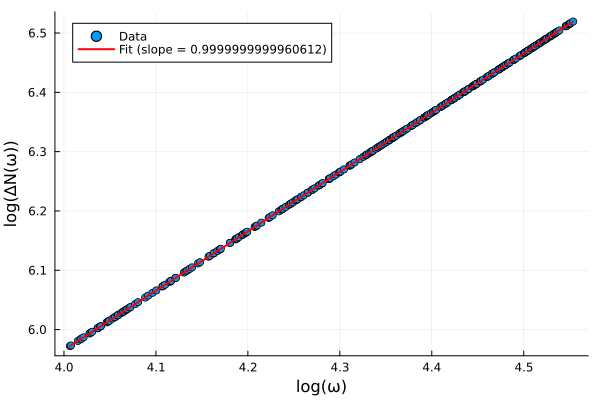

In [24]:
function Delta_N_of_omega(eigen_freq, vertices=vertices, d=d, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
    S = (x_max - x_min)*(y_max - y_min)
    L = length(vertices)*d
    return L*eigen_freq/(4*pi)
end

copy_results = deepcopy(results)  # Reset data
D = NaN  # Reset D to ensure it's recalculated

# Recompute frequency-related data
unique_freq = unique(round.(copy_results.eigen_frequency, digits=8))[100:end]  # Ensure consistency
log_Delta_N = log.(round.(Delta_N_of_omega(unique_freq), digits=8))  # FIXED: Using unique_freq
log_omega = log.(unique_freq)

# Recreate DataFrame
Weyl_Berry_data = DataFrame(log_Delta_N=log_Delta_N, log_omega=log_omega)
model = lm(@formula(log_Delta_N ~ log_omega), Weyl_Berry_data)

println("Model Summary:")
println(summary(model))

println(Weyl_Berry_data)

println("Coefficients: ", coef(model))
println("R-squared: ", r2(model))

D = coef(model)[2]
C = coef(model)[1]

# Get the standard error of the slope (D)
coeftab = coeftable(model)
std_error_D = coeftab.cols[2][2]  # The standard error is in the second column

println("The value of D is: ", D)
println("The standard deviation of D is: ", std_error_D)
println("Interval for D: [", D - 2*std_error_D, ", ", D + 2*std_error_D, "]")

Plots.scatter(Weyl_Berry_data.log_omega, Weyl_Berry_data.log_Delta_N, label="Data", xlabel="log(ω)", ylabel="log(∆N(ω))")
Plots.plot!(Weyl_Berry_data.log_omega, D*Weyl_Berry_data.log_omega .+ C, label="Fit (slope = $D)", linewidth=2, color=:red)
display(current())

The value of D is: 1.444
The standard deviation of D is: 0.034
Interval for D: [1.377, 1.511]
R² value: 0.803


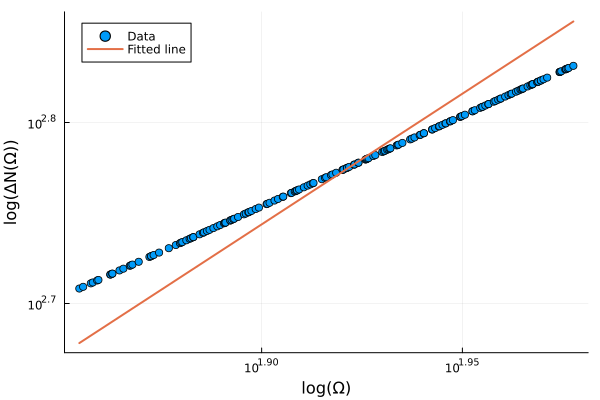

In [ ]:
function Delta_N_of_omega(eigen_freq, vertices=vertices, d=d, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
    """
    Calculates the quantity \(\Delta N(\omega)\), which depends on the eigenfrequency `eigen_freq`, 
    the length of the vertices `vertices`, and other geometric parameters of the grid.

    # Arguments
    - `eigen_freq`: The eigenfrequency for which \(\Delta N(\omega)\) is being calculated.
    - `vertices`: (Optional) Coordinates of the vertices, used to compute the length. Defaults to `vertices`.
    - `d`: (Optional) A parameter affecting the scaling of the length. Defaults to `d`.
    - `x_min`, `x_max`, `y_min`, `y_max`: (Optional) Limits for the x- and y-axes (used in the calculation of the area).

    # Returns
    Returns the computed value of \(\Delta N(\omega)\).
    """
    S = (x_max - x_min)*(y_max - y_min)
    L = length(vertices)*d
    return L*eigen_freq/(4*pi)
end

# Fit a linear model to log(Delta_N) vs log(unique_eigen_freq)
copy_results = deepcopy(results)  # Reset data
D = NaN  # Reset D to ensure it's recalculated

unique_freq = unique(round.(copy_results.eigen_frequency, digits=8))[200:end]  # Ensure consistency
log_omega = log.(unique_freq)
log_Delta_N = log.(Delta_N_of_omega.(unique_freq))

# Solve for coefficients (slope and intercept)
coefficients = log_omega \ log_Delta_N
D = coefficients
residuals_D = log_Delta_N .- (log_omega * coefficients)

n = length(log_omega)
s_yx = sqrt(sum(residuals_D .^ 2) / (n - 2))
s_xx = sum((log_omega .- Statistics.mean(log_omega)) .^ 2)
std_error_D = s_yx / sqrt(s_xx)

SS_res = sum(residuals_D .^ 2)
SS_tot = sum((log_Delta_N .- mean(log_Delta_N)) .^ 2)
R_squared = 1 - (SS_res / SS_tot)

# Print the result
println("The value of D is: ", round(D, digits=3))
println("The standard deviation of D is: ", round(std_error_D, digits=3))
println("Interval for D: [", round(D - 2*std_error_D, digits=3), ", ", round(D + 2*std_error_D, digits=3), "]")
println("R² value: ", round(R_squared, digits=3))

# Optionally, you can plot the data and the fitted line
linreg_plot = Plots.scatter(unique_freq, Delta_N_of_omega.(unique_freq), label="Data", xlabel="log(Ω)", ylabel="log(∆N(Ω))", xscale=:log10, yscale=:log10)
Plots.plot!(unique_freq, exp.(log_omega*coefficients), label="Fitted line", lw=2, xscale=:log10, yscale=:log10)
# Plots.savefig(linreg_plot, "linreg_plot.png")


In [26]:
println(log(Delta_N_of_omega(32.2002)))
println(log(32.2002))
println(log(Delta_N_of_omega(32.2002))/log(32.2002))

5.437628194063244
3.4719726637111976
1.566149483518961


In [27]:
println(results)

499×4 DataFrame
 Row │ mode_number  eigen_frequency  degeneracy  frequency_ratio 
     │ Int64        Float64          Int64       Float64         
─────┼───────────────────────────────────────────────────────────
   1 │           0          9.42994           1          2.12248
   2 │           1         14.1469            2          3.18417
   3 │           2         14.1469            2          3.18417
   4 │           3         14.4199            1          3.24562
   5 │           4         14.4969            1          3.26294
   6 │           5         15.0824            2          3.39473
   7 │           6         15.0824            2          3.39473
   8 │           7         17.6559            1          3.97397
   9 │           8         18.9114            1          4.25655
  10 │           9         19.4563            2          4.37921
  11 │          10         19.4563            2          4.37921
  12 │          11         20.021             1          4.5063
  13 │ 

## Task 7: Higher-Order Finite Difference Approximation

In [ ]:
function helmholtz_solver_9_point(square_grid, l)
    """
    Solves the Helmholtz equation on a square grid using a 9-point stencil with a 4th-order accurate finite difference scheme. 
    This function assembles a sparse matrix using the 9-point stencil, computes the eigenvalues and eigenvectors of the system, and returns the results.

    # Arguments
    - `square_grid`: Grid populated with values based on point position.
    - `l`: Fractal level. 

    # Returns
    A tuple containing:
    - `sqrt_eigen_modes`: The square root of the eigenvalues of the Helmholtz operator.
    - `eigen_vecs`: The eigenvectors corresponding to the computed eigenvalues.
    - `classification_matrix`: A matrix that assigns unique indices to the internal points of the grid.
    - `A`: The sparse matrix representing the Helmholtz operator.
    """

    # Grid size
    N = size(square_grid, 1)

    # Initialize classification matrix to assign unique indices to grid points
    classification_matrix = zeros(Int, N, N)
    
    # Point index counter, starts at 1
    p = 1
    
    # Grid spacing, determined by parameter l
    h = 4^l

    # Step 1: Assign unique indices to internal points (points inside the domain)
    for i in 1:N
        for j in 1:N
            # Only assign indices to points that are inside the domain (positive values in square_grid)
            if square_grid[i, j] > 0
                classification_matrix[i, j] = p
                p += 1
            end
        end
    end

    # Number of internal points (points with indices assigned)
    num_internal_points = p - 1

    # Arrays to store the non-zero entries of the sparse matrix (I, J for indices, V for values)
    I, J, V = Int[], Int[], Float64[]

    # Step 2: Define coefficients for the 4th-order accurate 9-point stencil
    C0 = 60*h^2/12  # Center coefficient
    C1 = -16*h^2/12 # Coefficients for nearest neighbors (orthogonal)
    C2 = h^2/12     # Coefficients for next-nearest neighbors (two steps away)

    # Total iterations for the progress bar (each point in the grid)
    total_iterations = N * N
    progress = Progress(total_iterations, 1)

    # Step 3: Loop over each grid point and build the sparse matrix for the Helmholtz operator
    for j in 1:N
        for i in 1:N
            # Get the classification index for the current point
            p = classification_matrix[i, j]

            # Process internal points only (points with assigned indices)
            if p > 0
                # Add center coefficient for the current point
                push!(I, p)
                push!(J, p)
                push!(V, C0)

                # Define 9-point stencil neighbors (orthogonal and next-nearest)
                neighbors = [
                    (i+1, j, C1), (i-1, j, C1), (i, j+1, C1), (i, j-1, C1),   # Orthogonal neighbors
                    (i+2, j, C2), (i-2, j, C2), (i, j+2, C2), (i, j-2, C2)    # Next-nearest neighbors (two steps away)
                ]
                
                # Loop through neighbors and add non-zero stencil coefficients
                for (m, n, coeff) in neighbors
                    # Ensure neighbors are within the grid bounds
                    if 1 <= m <= N && 1 <= n <= N
                        q = classification_matrix[m, n]
                        
                        # Add neighbor coefficients if the neighbor point is internal (has an index)
                        if q > 0
                            push!(I, p)
                            push!(J, q)
                            push!(V, coeff)
                        end
                    end
                end
            end
            next!(progress)  # Update the progress bar
        end
    end

    # Step 4: Construct sparse matrix A from the gathered I, J, and V arrays
    A = sparse(I, J, V, num_internal_points, num_internal_points)

    # Step 5: Compute the eigenvalues and eigenvectors of the sparse matrix A using the Arnoldi method
    nev = 500  # Number of eigenvalues to compute
    ncv = 1000 # Number of Arnoldi vectors to use
    maxiter = 10000  # Maximum number of iterations for the eigenvalue solver
    tol = 1e-6  # Tolerance for convergence

    # Compute eigenvalues and eigenvectors
    eigen_modes, eigen_vecs = eigs(A; nev=nev, ncv=ncv, which=:SM, maxiter=maxiter, tol=tol)
    
    # Take the square root of the eigenvalues (and ensure no negative values)
    sqrt_eigen_modes = sqrt.(max.(eigen_modes, 0))
    
    # Return the results: square root of eigenvalues, eigenvectors, classification matrix, and matrix A
    return sqrt_eigen_modes, eigen_vecs, classification_matrix, A
end

helmholtz_solver_9_point (generic function with 1 method)

In [29]:

results_9_point, modes_9_point = process_results(square_grid, l, fundamental_freq, helmholtz_solver_9_point)

Solving Helmholtz equation took 536.8 seconds.
500×4 DataFrame
 Row │ mode_number  eigen_frequency  degeneracy  frequency_ratio 
     │ Int64        Float64          Int64       Float64         
─────┼───────────────────────────────────────────────────────────
   1 │           0          9.44438           1          2.12573
   2 │           1         14.1809            2          3.19182
   3 │           2         14.1809            2          3.19182
   4 │           3         14.4561            1          3.25377
   5 │           4         14.532             1          3.27086
   6 │           5         15.1075            2          3.40039
   7 │           6         15.1075            2          3.40039
   8 │           7         17.6885            1          3.98132
   9 │           8         18.9501            1          4.26527
  10 │           9         19.4969            2          4.38835
  11 │          10         19.4969            2          4.38835
  12 │          11      

(500×4 DataFrame
 Row │ mode_number  eigen_frequency  degeneracy  frequency_ratio 
     │ Int64        Float64          Int64       Float64         
─────┼───────────────────────────────────────────────────────────
   1 │           0          9.44438           1          2.12573
   2 │           1         14.1809            2          3.19182
   3 │           2         14.1809            2          3.19182
   4 │           3         14.4561            1          3.25377
   5 │           4         14.532             1          3.27086
   6 │           5         15.1075            2          3.40039
   7 │           6         15.1075            2          3.40039
   8 │           7         17.6885            1          3.98132
  ⋮  │      ⋮              ⋮             ⋮              ⋮
 494 │         493         95.1517            2         21.4167
 495 │         494         95.1517            2         21.4167
 496 │         495         95.1911            1         21.4255
 497 │         

In [24]:
# for k in 1:16
#     plot_modes_wireframe(square_grid, modes_9_point, k, "9-point")
# end

In [25]:
# for k in 1:16
#     plot_modes_2d_heatmap(square_grid, modes_9_point, k, "9-point")
# end

In [ ]:
# Fit a linear model to log(Delta_N) vs log(unique_eigen_freq)
copy_results_9_point = deepcopy(results_9_point)  # Reset data
D_9_point = NaN  # Reset D to ensure it's recalculated

unique_freq_9_point = unique(round.(copy_results_9_point.eigen_frequency, digits=8))[100:end]  # Ensure consistency
log_omega_9_point = log.(unique_freq_9_point)
log_Delta_N_9_point = log.(Delta_N_of_omega.(unique_freq_9_point))

# Solve for coefficients (slope and intercept)
coefficients_9_point = log_omega_9_point \ log_Delta_N_9_point
D_9_point = coefficients_9_point
residuals_D_9_point = log_Delta_N_9_point .- (log_omega_9_point * coefficients_9_point)

n_9_point = length(log_omega_9_point)
s_yx_9_point = sqrt(sum(residuals_D_9_point .^ 2) / (n - 2))
s_xx_9_point = sum((log_omega_9_point .- Statistics.mean(log_omega_9_point)) .^ 2)
std_error_D_9_point = s_yx_9_point / sqrt(s_xx_9_point)

SS_res_9_point = sum(residuals_D_9_point .^ 2)
SS_tot_9_point = sum((log_Delta_N_9_point .- mean(log_Delta_N_9_point)) .^ 2)
R_squared_9_point = 1 - (SS_res_9_point / SS_tot_9_point)

# Print the result
println("The value of D is: ", round(D_9_point, digits=3))
println("The standard deviation of D is: ", round(std_error_D_9_point, digits=3))
println("Interval for D: [", round(D_9_point - 2*std_error_D_9_point, digits=3), ", ", round(D + 2*std_error_D_9_point, digits=3), "]")
println("R² value: ", round(R_squared_9_point, digits=3))

# Optionally, you can plot the data and the fitted line
linreg_temp = Plots.scatter(unique_freq_9_point, Delta_N_of_omega.(unique_freq_9_point), label="Data", xlabel="log(Ω)", ylabel="log(∆N(Ω))", xscale=:log10, yscale=:log10)
linreg_temp = Plots.plot!(unique_freq_9_point, exp.(log_omega_9_point*coefficients_9_point), label="Fitted line", lw=2, xscale=:log10, yscale=:log10)
# Plots.savefig(linreg_temp, "linreg_9_stencil_l4.png")

The value of D is: 1.454
The standard deviation of D is: 0.034
Interval for D: [1.385, 1.513]
R² value: 0.794


"c:\\Users\\audso\\OneDrive\\Dokumenter\\Fysikk og matematikk\\10. semester\\numerical physics\\project 2\\linreg_9_stencil_l4.png"

## Task 8: Biharmonic Eigenvalue Problem for a Clamped Thin Plate

In [ ]:
function biharmonic_eq_solver(square_grid, l)
    """
    Solves the biharmonic equation on a square grid using a 9-point stencil with a 4th-order accurate finite difference scheme. 
    This function assembles a sparse matrix using the 9-point stencil for the biharmonic operator, computes the eigenvalues and eigenvectors of the system, and returns the results.

    # Arguments
    - `square_grid`: Grid populated with values based on point position.
    - `l`: Fractal level.

    # Returns
    A tuple containing:
    - `eigen_modes`: The eigenvalues of the biharmonic operator.
    - `eigen_vecs`: The eigenvectors corresponding to the computed eigenvalues.
    - `classification_matrix`: A matrix that assigns unique indices to the internal points of the grid.
    - `A`: The sparse matrix representing the biharmonic operator.
    """

    # Grid size
    N = size(square_grid, 1)

    # Initialize classification matrix to assign unique indices to grid points
    classification_matrix = zeros(Int, N, N)
    
    # Point index counter, starts at 1
    p = 1
    
    # Grid spacing, determined by parameter l
    h = 4.0^l

    # Step 1: Assign unique indices to internal points (points inside the domain)
    for i in 1:N
        for j in 1:N
            # Only assign indices to points that are inside the domain (positive values in square_grid)
            if square_grid[i, j] > 0
                # Check if the point has neighbors in all four directions (internal point check)
                if square_grid[i+1, j] > 0 && square_grid[i-1, j] > 0 && square_grid[i, j+1] > 0 && square_grid[i, j-1] > 0
                    classification_matrix[i, j] = p
                    p += 1
                end
            end
        end
    end

    # Number of internal points (points with indices assigned)
    num_internal_points = p - 1

    # Arrays to store the non-zero entries of the sparse matrix (I, J for indices, V for values)
    I, J, V = Int[], Int[], Float64[]

    # Step 2: Define coefficients for the 4th-order accurate 9-point stencil
    C0 = 20*h^4  # Center coefficient for biharmonic operator
    C1 = -8*h^4  # Coefficients for nearest neighbors (orthogonal)
    Cdiag = 2*h^4  # Diagonal neighbors
    C2 = h^4      # Coefficients for next-nearest neighbors (two steps away)

    # Loop over each grid point and build the sparse matrix for the biharmonic operator
    for j in 1:N
        for i in 1:N
            # Get the classification index for the current point
            p = classification_matrix[i, j]

            # Process internal points only (points with assigned indices)
            if p > 0
                # Add center coefficient for the current point (biharmonic operator)
                push!(I, p)
                push!(J, p)
                push!(V, C0)

                # Define 9-point stencil neighbors (orthogonal, diagonal, and next-nearest)
                neighbors = [
                    (i+1, j, C1), (i-1, j, C1), (i, j+1, C1), (i, j-1, C1),   # Orthogonal neighbors
                    (i+1, j+1, Cdiag), (i+1, j-1, Cdiag), (i-1, j-1, Cdiag), (i-1, j+1, Cdiag),  # Diagonal neighbors
                    (i+2, j, C2), (i-2, j, C2), (i, j+2, C2), (i, j-2, C2)    # Two steps away neighbors
                ]
                
                # Loop through neighbors and add non-zero stencil coefficients
                for (m, n, coeff) in neighbors
                    # Ensure neighbors are within the grid bounds
                    if 1 <= m <= N && 1 <= n <= N
                        q = classification_matrix[m, n]
                        
                        # Add neighbor coefficients if the neighbor point is internal (has an index)
                        if q > 0
                            push!(I, p)
                            push!(J, q)
                            push!(V, coeff)
                        end
                    end
                end
            end
        end
    end

    # Step 3: Construct sparse matrix A from the gathered I, J, and V arrays
    A = sparse(I, J, V, num_internal_points, num_internal_points)

    # Step 4: Compute eigenvalues and eigenvectors of the sparse matrix A using the Arnoldi method
    nev = 4  # Number of eigenvalues to compute
    ncv = 20 # Number of Arnoldi vectors to use
    maxiter = 100000  # Maximum number of iterations for the eigenvalue solver
    tol = 1e-3  # Tolerance for convergence

    # Compute eigenvalues and eigenvectors
    eigen_modes, eigen_vecs = eigs(A; nev=nev, ncv=ncv, which=:SM, maxiter=maxiter, tol=tol)
    
    # Return the results: eigenvalues, eigenvectors, classification matrix, and matrix A
    return eigen_modes, eigen_vecs, classification_matrix, A
end


biharmonic_eq_solver (generic function with 1 method)

In [ ]:
# eigen_modes_bih, _, _, _ = biharmonic_eq_solver(square_grid2, l)
# println(eigen_modes_bih)
l = 4
results_biharmonic, modes_biharmonic = process_results(square_grid, l, fundamental_freq, biharmonic_eq_solver)

In [ ]:
for k in 1:4
    temp_plot = plot_modes_wireframe(square_grid, modes_biharmonic, k, "biharmonic")
end

In [ ]:
for k in 1:4
    plot_modes_2d_heatmap(square_grid, modes_biharmonic, k, "biharmonic")
end

The value of D is: 1.098
The standard deviation of D is: 0.019
Interval for D: [1.061, 1.135]
R² value: 0.99


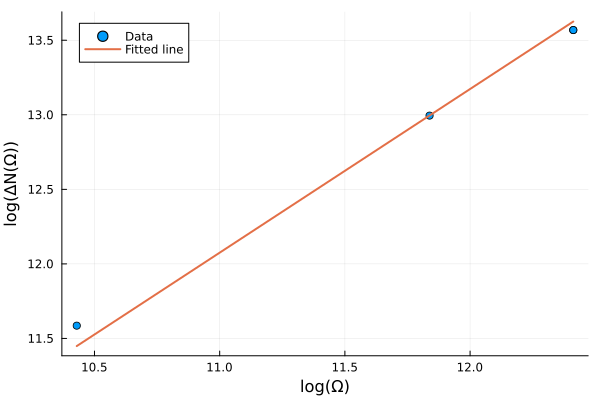

In [31]:
# Fit a linear model to log(Delta_N) vs log(unique_eigen_freq)
copy_results_biharmonic = deepcopy(results_biharmonic)  # Reset data
D_biharmonic = NaN  # Reset D to ensure it's recalculated

unique_freq_biharmonic = unique(round.(copy_results_biharmonic.eigen_frequency, digits=8))  # Ensure consistency
log_omega_biharmonic = log.(unique_freq_biharmonic)
log_Delta_N_biharmonic = log.(Delta_N_of_omega.(unique_freq_biharmonic))

# Solve for coefficients (slope and intercept)
coefficients_biharmonic = log_omega_biharmonic \ log_Delta_N_biharmonic
D_biharmonic = coefficients_biharmonic
residuals_D_biharmonic = log_Delta_N_biharmonic .- (log_omega_biharmonic * coefficients_biharmonic)

n_biharmonic = length(log_omega_biharmonic)
s_yx_biharmonic = sqrt(sum(residuals_D_biharmonic .^ 2) / (n - 2))
s_xx_biharmonic = sum((log_omega_biharmonic .- Statistics.mean(log_omega_biharmonic)) .^ 2)
std_error_D_biharmonic = s_yx_biharmonic / sqrt(s_xx_biharmonic)

SS_res_biharmonic = sum(residuals_D_biharmonic .^ 2)
SS_tot_biharmonic = sum((log_Delta_N_biharmonic .- mean(log_Delta_N_biharmonic)) .^ 2)
R_squared_biharmonic = 1 - (SS_res_biharmonic / SS_tot_biharmonic)

# Print the result
println("The value of D is: ", round(D_biharmonic, digits=3))
println("The standard deviation of D is: ", round(std_error_D_biharmonic, digits=3))
println("Interval for D: [", round(D_biharmonic - 2*std_error_D_biharmonic, digits=3), ", ", round(D_biharmonic + 2*std_error_D_biharmonic, digits=3), "]")
println("R² value: ", round(R_squared_biharmonic, digits=3))

# Optionally, you can plot the data and the fitted line
Plots.scatter(log_omega_biharmonic, log_Delta_N_biharmonic, label="Data", xlabel="log(Ω)", ylabel="log(∆N(Ω))")
Plots.plot!(log_omega_biharmonic, log_omega_biharmonic * coefficients_biharmonic, label="Fitted line", lw=2)